In [1]:
import torch
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

In [2]:
# GPU
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('GPU State:', device)

GPU State: cuda:0


In [3]:
# Transform
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,)),]
)

In [4]:
# Data
trainSet = datasets.MNIST(root='MNIST', download=True, train=True, transform=transform)
testSet = datasets.MNIST(root='MNIST', download=True, train=False, transform=transform)
trainLoader = torch.utils.data.DataLoader(trainSet, batch_size=64, shuffle=True, num_workers=16)
testLoader = torch.utils.data.DataLoader(testSet, batch_size=64, shuffle=False, num_workers=16)

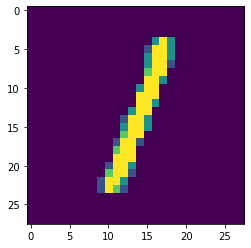

In [5]:
import matplotlib.pyplot as plt

plt.imshow(np.rollaxis(list(trainLoader)[0][0][0].numpy(),0,3))

In [14]:
# Model
writer = SummaryWriter()

# class Net(torch.nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.main = torch.nn.Sequential(
#             torch.nn.Linear(in_features=784, out_features=128),
#             torch.nn.ReLU(),
#             torch.nn.Linear(in_features=128, out_features=64),
#             torch.nn.ReLU(),
#             torch.nn.Linear(in_features=64, out_features=10),
#             torch.nn.LogSoftmax(dim=1)
#         )

#     def forward(self, input):
#         return self.main(input)
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.main = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=10, kernel_size=2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=10, out_channels=20, kernel_size=2),
            torch.nn.Flatten(),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=20*676, out_features=10),
            torch.nn.Softmax(dim=1)
        )

    def forward(self, input):
        return self.main(input)

net = Net().to(device)
print(net)

Net(
  (main): Sequential(
    (0): Conv2d(1, 10, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 20, kernel_size=(2, 2), stride=(1, 1))
    (3): Flatten()
    (4): ReLU()
    (5): Linear(in_features=13520, out_features=10, bias=True)
    (6): Softmax(dim=1)
  )
)


In [15]:
# Parameters
epochs = 100
lr = 0.001
loss_fn = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(net.parameters(), lr=0.002, momentum=0.9)
optimizer = torch.optim.Adam(net.parameters(), lr=0.002)

In [16]:
# Train
epoch_loss = []
epoch_acc = []
for epoch in range(epochs):
    running_loss = 0.0
    running_acc = 0.0
    for times, data in enumerate(trainLoader):
        inputs, labels = data[0].to(device), data[1].to(device)
        
#         inputs = inputs.view(inputs.shape[0], -1)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Foward + backward + optimize
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        running_acc +=  (labels==predicted).sum().item()
    _epoch_loss = running_loss/len(trainLoader)
    _epoch_acc = running_acc/len(trainLoader)
    epoch_acc.append(_epoch_acc)
    epoch_loss.append(_epoch_loss)
    print(epoch, _epoch_loss, _epoch_acc)
#     writer.add_scalar('Loss/train', np.random.random(), n_iter)
#     writer.add_scalar('Loss/test', np.random.random(), n_iter)
#     writer.add_scalar('Accuracy/train', np.random.random(), n_iter)
#     writer.add_scalar('Accuracy/test', np.random.random(), n_iter)
print('Training Finished.')

0 1.562944191859475 57.682302771855014
1 1.4944222052214242 61.91577825159915
2 1.4855380752193394 62.427505330490405
3 1.4809300572887412 62.733475479744136
4 1.4783514609723203 62.8955223880597
5 1.4773077301379205 62.94136460554371
6 1.4751969129800289 63.085287846481876
7 1.4732363240551085 63.20575692963752
8 1.4718633553366671 63.29957356076759
9 1.4729930008652368 63.21855010660981
10 1.4724777086711387 63.25586353944563
11 1.470609131016965 63.36460554371002
12 1.4702944919498744 63.38805970149254
13 1.4702447744320706 63.38486140724947
14 1.4697181745124523 63.41897654584222
15 1.4689984458850136 63.47334754797441
16 1.4691390148612227 63.45522388059702
17 1.4689469071847798 63.47228144989339
18 1.468368450080408 63.50959488272921
19 1.4682015827469734 63.51705756929638
20 1.4686466963814775 63.486140724946694
21 1.46791520327139 63.5319829424307
22 1.467904738017491 63.53518123667377
23 1.4673894261246296 63.56716417910448
24 1.4674859827261235 63.556503198294244
25 1.4672714

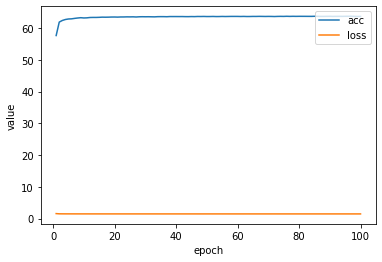

In [17]:
x = np.linspace(1, epochs, num=epochs)
plt.plot(x, epoch_acc, label='acc')
plt.plot(x, epoch_loss, label='loss')
plt.legend(loc="upper right")
plt.xlabel("epoch")
plt.ylabel("value")
plt.show()

In [18]:
correct = 0
total = 0

with torch.no_grad():
    for data in testLoader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
#         inputs = inputs.view(inputs.shape[0], -1)

        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100*correct / total))

class_correct = [0 for i in range(10)]
class_total = [0 for i in range(10)]

with torch.no_grad():
    for data in testLoader:
        inputs, labels = data[0].to(device), data[1].to(device)
#         inputs = inputs.view(inputs.shape[0], -1)

        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(10):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
            print(class_correct)
            print(class_total)

for i in range(10):
    print('Accuracy of %d: %3f' % (i, (class_correct[i]/class_total[i])))

Accuracy of the network on the 10000 test images: 98 %
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
[0, 0, 1, 0, 0, 0, 0, 1, 0, 0]
[0, 0, 1, 0, 0, 0, 0, 1, 0, 0]
[0, 1, 1, 0, 0, 0, 0, 1, 0, 0]
[0, 1, 1, 0, 0, 0, 0, 1, 0, 0]
[1, 1, 1, 0, 0, 0, 0, 1, 0, 0]
[1, 1, 1, 0, 0, 0, 0, 1, 0, 0]
[1, 1, 1, 0, 1, 0, 0, 1, 0, 0]
[1, 1, 1, 0, 1, 0, 0, 1, 0, 0]
[1, 2, 1, 0, 1, 0, 0, 1, 0, 0]
[1, 2, 1, 0, 1, 0, 0, 1, 0, 0]
[1, 2, 1, 0, 2, 0, 0, 1, 0, 0]
[1, 2, 1, 0, 2, 0, 0, 1, 0, 0]
[1, 2, 1, 0, 2, 0, 0, 1, 0, 1]
[1, 2, 1, 0, 2, 0, 0, 1, 0, 1]
[1, 2, 1, 0, 2, 1, 0, 1, 0, 1]
[1, 2, 1, 0, 2, 1, 0, 1, 0, 1]
[1, 2, 1, 0, 2, 1, 0, 1, 0, 2]
[1, 2, 1, 0, 2, 1, 0, 1, 0, 2]
[1, 2, 1, 0, 2, 1, 0, 2, 0, 2]
[1, 2, 1, 0, 2, 1, 0, 2, 0, 2]
[1, 2, 1, 0, 3, 1, 0, 2, 0, 2]
[1, 2, 1, 0, 3, 1, 0, 2, 0, 2]
[1, 2, 1, 0, 3, 1, 1, 2, 0, 2]
[1, 2, 1, 0, 3, 1, 1, 2, 0, 2]
[1, 2, 1, 0, 4, 1, 1, 2, 0, 2]
[1, 2, 1, 0, 4, 1, 1, 2, 0, 2]
[1, 2, 1, 1, 4, 1, 1, 2, 0, 2]
[1, 2, 1, 1, 4, 1, 1, 2, 0, 2]
[2, 2, 1, 1, 4,